# Efficiency vs Performance Metrics

Welcome! In this hands on lab, you'll explore the important balance between a model's performance and its efficiency. As you've learned, building effective machine learning solutions involves more than just aiming for the highest accuracy. Applications in the real world often have strict limits on model size, inference time, and memory usage that you must consider alongside predictive power.

In this notebook, you will take a systematic approach to compare and select models by combining both performance and efficiency standards.

Specifically, you’ll learn to:

* **Train diverse models**: You will train two different convolutional neural networks on the CIFAR10 dataset: a compact, lightweight CNN and the deeper ResNet34 architecture.

* **Evaluate key efficiency metrics**: You will use provided utility functions to measure and analyze each model's size, inference speed, and memory footprint.

* **Apply model selection strategies**: You will experiment with two methods for choosing the best model: a weighted scoring system that balances multiple factors and a constraint based approach that filters models based on hard limits.

By practicing these strategies, you'll gain practical experience in balancing model complexity with predictive quality. These skills are essential for designing and deploying robust, efficient deep learning systems in production environments.

## Imports

In [1]:
import time
from pprint import pprint

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
import torchvision.transforms as transforms

import helper_utils
import model_architectures

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Beyond Performance: Considering Efficiency

Model selection in deep learning should not be based solely on standard performance metrics such as accuracy or F1 score. Especially in real-world applications, it is important to account for efficiency metrics that impact model deployment and usability. 

**Efficiency metrics** include but are not limited to:
- **Model size:** The memory footprint of the model, often measured in megabytes.
- **Inference time:** The average time required for the model to make predictions on new data.

Evaluating these metrics allows for a more comprehensive comparison between models, helping to balance predictive performance with practical requirements such as speed and resource constraints.

### Comparing Two Models

In the following sections, two models are trained and evaluated on the CIFAR10 dataset:
- **OptimizedCNN:** A compact convolutional neural network composed of a small number of convolutional layers.
- **ResNet34:** A deeper and more complex architecture, consisting of 34 layers designed for high performance.

Both models will be compared not only in terms of accuracy but also with respect to model size and inference time. 

In [3]:
# OptimizedCNN
model_CNN = model_architectures.OptimizedCNN()

# ResNet-34
model_resnet = model_architectures.ResNet34()

### Training and Evaluation

The following code demonstrates how to train and evaluate two different models on the CIFAR10 dataset. 

- The `get_data_loaders_with_validation` function is used to create DataLoader instances for the training, validation, and test splits. The training and validation loaders are used during model training and hyperparameter tuning, while the test loader is reserved for final model evaluation.

In [4]:
def get_data_loaders_with_validation(batch_size, val_fraction=0.1):
    """Creates and returns data loaders for training, validation, and testing.

    Args:
        batch_size: The number of samples per batch in each data loader.
        val_fraction: The fraction of the training data to use for validation.

    Returns:
        A tuple containing the training, validation, and test data loaders.
    """
    # Define the transformations for the training data, including augmentation.
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Define the transformations for the validation and test data (no augmentation).
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the full CIFAR-10 training dataset.
    full_trainset = datasets.CIFAR10(root='./cifar10', train=True, download=True, transform=transform_train)
    # Calculate the number of samples for the training and validation sets.
    total_train = len(full_trainset)
    val_size = int(val_fraction * total_train)
    train_size = total_train - val_size

    # Split the full training set into separate training and validation sets.
    train_set, val_set = random_split(full_trainset, [train_size, val_size])

    # Apply the non-augmented test transform to the validation set.
    val_set.dataset.transform = transform_test

    # Load the CIFAR-10 test dataset.
    test_set = datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform_test)

    # Create DataLoader instances for each dataset split.
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    # Return the created data loaders.
    return train_loader, val_loader, test_loader

- The `train_and_evaluate` function performs the training loop for a specified number of epochs, evaluating model performance on the validation set at the end of each epoch. 

In [5]:
def train_and_evaluate(model, optimizer, scheduler, device, n_epochs, train_loader, val_loader):
    """Manages the main training and evaluation loop for a model.

    Args:
        model: The PyTorch model to train.
        optimizer: The optimizer for updating model weights.
        scheduler: The learning rate scheduler (can be None).
        device: The device ('cpu' or 'cuda') to perform computations on.
        n_epochs: The total number of epochs to train for.
        train_loader: The DataLoader for the training data.
        val_loader: The DataLoader for the validation data.
    """
    # Move the model to the specified compute device.
    model = model.to(device)

    # Define the loss function.
    loss_fcn = nn.CrossEntropyLoss()

    # Initialize the progress bar for visualizing the training process.
    pbar = helper_utils.NestedProgressBar(total_epochs=n_epochs, total_batches=len(train_loader), epoch_message_freq=1)

    # Loop through the specified number of epochs.
    for epoch in range(n_epochs):
        # Update the epoch-level progress bar for the new epoch.
        pbar.update_epoch(epoch+1)

        # Perform one epoch of training and get the average training loss.
        train_loss, _ = helper_utils.train_epoch(model, train_loader, optimizer, loss_fcn, device, pbar)
        
        # Evaluate the model's accuracy on the validation set.
        val_acc = helper_utils.evaluate_accuracy(model, val_loader, device)

        # Log the training loss and validation accuracy for the current epoch.
        pbar.maybe_log_epoch(epoch+1, message=f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Check if a learning rate scheduler is being used.
        if scheduler is not None:
            # Handle the ReduceLROnPlateau scheduler, which requires a metric.
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            # For other schedulers, step without a metric.
            else:
                scheduler.step()

    # Close the progress bar and print a final completion message.
    pbar.close("Training complete!")

Now you will train the two models and evaluate them.
Two different optimizers are used: `Adam` for `OptimizedCNN` and `SGD` for `ResNet34`.
You will also use a learning rate scheduler to adjust the learning rate during training.

In [6]:
n_epochs = 10

# Data loaders
batch_size = 128
train_loader, val_loader, test_loader = get_data_loaders_with_validation(batch_size=batch_size, val_fraction=0.1)

In [7]:
optimizer_CNN = optim.Adam(model_CNN.parameters(), lr=0.001, weight_decay=1e-5)
scheduler_CNN = optim.lr_scheduler.ReduceLROnPlateau(optimizer_CNN, 'max', patience=3, factor=0.5)

# Train and evaluate the OptimizedCNN model
train_and_evaluate(model_CNN, optimizer_CNN, scheduler_CNN, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 1.4622, Val Acc: 0.5912


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.0169, Val Acc: 0.6530


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 0.8772, Val Acc: 0.6916


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 0.7888, Val Acc: 0.7184


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.7204, Val Acc: 0.7012


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.6614, Val Acc: 0.7474


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.6141, Val Acc: 0.7532


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.5525, Val Acc: 0.7284


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.5102, Val Acc: 0.7504


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.4720, Val Acc: 0.7656
Training complete!


In [8]:
optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=200)

# Train and evaluate the ResNet-34 model
train_and_evaluate(model_resnet, optimizer_resnet, scheduler_resnet, device, n_epochs, train_loader, val_loader)

Current Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Current Batch:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 2.0763, Val Acc: 0.3836


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 1.5072, Val Acc: 0.4870


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 1.2681, Val Acc: 0.5232


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 1.0585, Val Acc: 0.6392


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 0.8908, Val Acc: 0.6596


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 0.7637, Val Acc: 0.7082


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 0.6526, Val Acc: 0.7550


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 0.5547, Val Acc: 0.7644


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 0.4863, Val Acc: 0.7488


Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 0.4098, Val Acc: 0.7410
Training complete!


## Evaluating Model Efficiency

When comparing machine learning models, it is important to consider their efficiency in addition to their predictive performance. 
In practical scenarios, factors such as model size and inference time may significantly affect the choice of model, especially when deploying on resource-constrained devices.

In this section, efficiency metrics will be computed for the trained models. By calculating these metrics, one can compare models not just by accuracy but also by how efficiently they use computational resources.

- `get_model_size`: Calculates the total memory size of the model in megabytes (MB), considering both trainable parameters and non-trainable buffers.
    - The function iterates over all parameters using `model.parameters()`. For each parameter, it multiplies the number of elements (`param.nelement()`) by the size in bytes of each element (`param.element_size()`), accumulating the total in `param_size`.
    - It repeats this process for non-trainable buffers, accessed via `model.buffers()`, accumulating their total size in `buffer_size`.
    - The final model size in MB is computed as `(param_size + buffer_size) / 1024**2`.

In [9]:
def get_model_size(model):
    """Calculates the total size of a PyTorch model in megabytes (MB).

    Args:
        model: The PyTorch model (nn.Module) whose size is to be calculated.

    Returns:
        The total size of the model in megabytes (MB).
    """
    # Initialize a variable to store the size of trainable parameters.
    param_size = 0
    # Iterate over all model parameters.
    for param in model.parameters():
        # Add the size of the current parameter to the total.
        param_size += param.nelement() * param.element_size()

    # Initialize a variable to store the size of non-trainable buffers.
    buffer_size = 0
    # Iterate over all model buffers.
    for buffer in model.buffers():
        # Add the size of the current buffer to the total.
        buffer_size += buffer.nelement() * buffer.element_size()

    # Calculate the total size in megabytes.
    size_in_mb = (param_size + buffer_size) / 1024**2
    # Return the final calculated size.
    return size_in_mb

- `measure_inference_time`: 
Estimates the average time taken by the model to perform inference on a batch of input data.
    - The model is set to evaluation mode using `model.eval()`.
    - The input data is moved to the same device as the model with `input_data.to(device)`.
    - A short warmup loop is run to ensure accurate timing.
    - The inference time is measured by running the model forward pass `num_iterations` times inside a `torch.no_grad()` block and computing the elapsed time.
    - The function returns the average inference time per pass, converted from seconds to milliseconds (`ms`).

In [10]:
def measure_inference_time(model, input_data, num_iterations=100):
    """Measures the average inference time of a model for a given input.

    Args:
        model: The PyTorch model (nn.Module) to be benchmarked.
        input_data: A sample input tensor for the model.
        num_iterations: The number of times to run inference for averaging.

    Returns:
        The average inference time in milliseconds (ms).
    """
    # Set the model to evaluation mode to disable layers like dropout.
    model.eval()

    # Get the device the model is currently on.
    device = next(model.parameters()).device
    # Move the input data to the same device as the model.
    input_data = input_data.to(device)

    # Perform a few warmup runs to allow for GPU caching and other setup.
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_data)

    # Record the start time before the main measurement loop.
    start_time = time.time()
    # Run inference for the specified number of iterations without calculating gradients.
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(input_data)
    # Record the end time after the loop finishes.
    end_time = time.time()

    # Calculate the average time per iteration.
    avg_time = (end_time - start_time) / num_iterations
    # Convert the average time from seconds to milliseconds and return it.
    return avg_time * 1000

### Model Efficiency and Performance Comparison

The `evaluate_efficiency` function provides a comprehensive summary of a model's key efficiency and performance metrics. 
- The function calls `get_model_size(model)` to compute the total memory required to store the model's parameters and buffers. 

- A batch of input data is extracted from the test loader, and a representative sample (`sample_input`) is created by selecting a single input and moving it to the correct device. 
The function then uses `measure_inference_time(model, sample_input)` to determine the average time (in milliseconds) needed for the model to process a single input.

- The model's accuracy is evaluated using the `helper_utils.evaluate_accuracy(model, test_loader, device)` function, which computes the ratio of correct predictions to total samples in the test set.

The results are packaged in a dictionary with keys for `"accuracy"`, `"model_size_mb"`, and `"inference_time_ms"`. 

In [11]:
def evaluate_efficiency(model, test_loader, device):
    """Evaluates the efficiency of a model based on several key metrics.

    This function calculates the model's accuracy on a test set, its total
    size in megabytes, and its average inference time in milliseconds.

    Args:
        model: The PyTorch model (nn.Module) to be evaluated.
        test_loader: The DataLoader providing the test dataset.
        device: The device ('cpu' or 'cuda') on which to perform the evaluation.

    Returns:
        A dictionary containing the model's 'accuracy', 'model_size_mb',
        and 'inference_time_ms'.
    """
    # Calculate the model's size in megabytes.
    model_size = get_model_size(model)

    # Create an iterator to get a single batch for inference time measurement.
    data_iter = iter(test_loader)
    batch = next(data_iter)
    # Extract the input tensors from the batch.
    inputs = batch[0]
    # Create a single-sample batch and move it to the correct device.
    sample_input = inputs[:1].to(device)
    # Measure the average inference time using the sample input.
    inf_time = measure_inference_time(model, sample_input)

    # Calculate the model's accuracy on the entire test set.
    test_accuracy = helper_utils.evaluate_accuracy(model, test_loader, device)

    # Return the collected efficiency metrics in a dictionary.
    return {
        "accuracy": test_accuracy,
        "model_size_mb": model_size,
        "inference_time_ms": inf_time,
    }

In [12]:
models = {
    "Optimized_CNN": model_CNN,
    "ResNet34": model_resnet
}

results = {}
for name, model in models.items():
    results[name] = evaluate_efficiency(model, test_loader, device)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results).T
print(results_df)

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

               accuracy  model_size_mb  inference_time_ms
Optimized_CNN    0.7612       9.196831           0.343840
ResNet34         0.7378      81.250069           3.592744


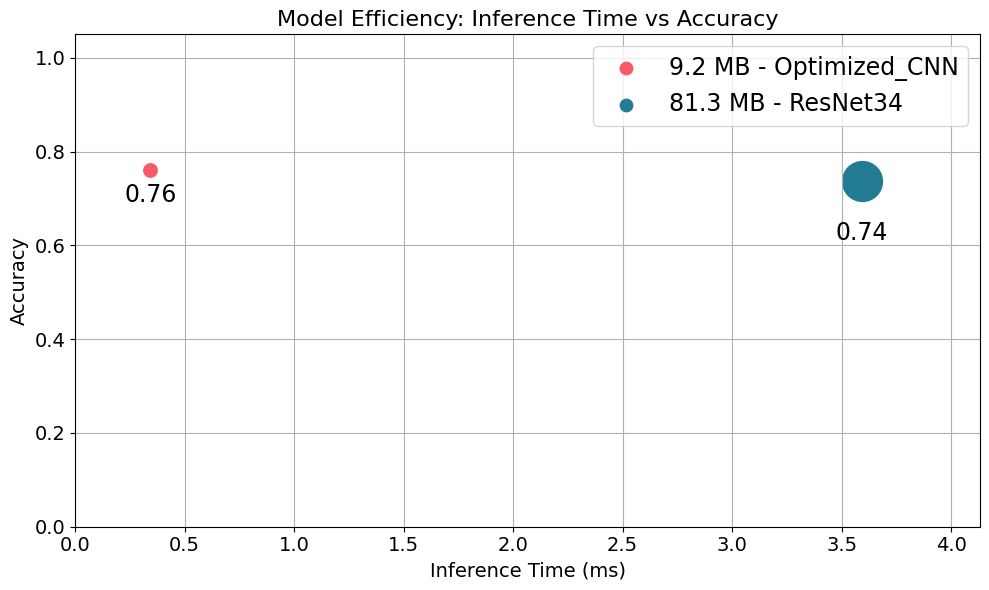

In [13]:
helper_utils.plot_efficiency_analysis(results_df)

### Model Selection based on constraints and weighted criteria

When considering both performance and efficiency, model selection becomes a multi-objective decision. 
Instead of choosing a model solely based on accuracy, you may want to account for additional factors such as model size and inference time.

In this section, you are provided with a table containing several ResNet models.  
Each model has different values for size, inference time, and accuracy.  
Although these models are not trained within this notebook (the values are hypothetical and might correspond to results after 100 epochs), you can apply the same selection methods to any set of models, just like you did for `OptimizedCNN` and `ResNet34`.

In the cells bellow you will find two different approaches for model selection `select_best_model_weighted` and `select_best_model_constraint_based`.

These functions encapsulate the main ingredients of a robust model selection pipeline: conversion and normalization of metrics, flexible weighting, hard constraint enforcement, and clear reporting of results. The structured approach ensures models are chosen according to both application requirements and available resources.

- `select_best_model_weighted`: Systematically selects the optimal model by combining normalized model metrics into a single score using customizable weights.
    - The input `results` is first converted to a dictionary using `results.to_dict(orient="index")`, enabling direct access to model entries.
    - Metric weights can be specified (e.g., `weights = {"accuracy": 0.6, "model_size_mb": 0.2, "inference_time_ms": 0.2}`) or left as defaults to prioritize accuracy.
    - Normalization of each metric occurs across all models: 
        - For `"accuracy"`, normalization is performed so that higher scores are better using  
          `norm_value = (value - min_val) / range_val`.
        - For `"model_size_mb"` and `"inference_time_ms"`, normalization rewards smaller values via  
          `norm_value = 1 - (value - min_val) / range_val`.
    - The weighted sum for each model is computed as  
      `sum(weights[metric] * normalized[name][metric] for metric in metrics)`, aggregating the influence of all metrics based on their importance.
    - The model with the highest combined score is chosen with  
      `best_model = max(scores.items(), key=lambda x: x[1])`.
    - The function returns both the name of the best model and the scores for all evaluated models, providing transparency and flexibility for analysis.

In [14]:
def select_best_model_weighted(results, weights=None):
    """Selects the best model from a set of results using a weighted scoring system.

    Args:
        results: A pandas DataFrame containing model performance metrics,
                 with model names as the index.
        weights: An optional dictionary where keys are metric names (e.g.,
                 'accuracy') and values are their corresponding weights.
                 If None, default weights are used.

    Returns:
        A tuple containing the name of the best model and a dictionary of
        all models' weighted scores.
    """
    # Convert the DataFrame to a dictionary for easier processing.
    results = results.to_dict(orient="index")
    
    # If no weights are provided, define a default set that prioritizes accuracy.
    if weights is None:
        weights = {"accuracy": 0.5, "model_size_mb": 0.2, "inference_time_ms": 0.3}

    # Get the list of metrics to be considered from the weights dictionary.
    metrics = list(weights.keys())
    # Initialize a dictionary to store the normalized metric values for each model.
    normalized = {name: {} for name in results}

    # Loop through each metric to normalize its values across all models.
    for metric in metrics:
        # Extract all values for the current metric to find the min and max.
        values = [res[metric] for res in results.values()]
        min_val, max_val = min(values), max(values)
        # Calculate the range of values, avoiding division by zero.
        range_val = max_val - min_val if max_val != min_val else 1.0

        # Iterate through each model's results to calculate its normalized score.
        for name, res in results.items():
            value = res[metric]
            # Check the metric type to determine the normalization direction.
            if metric == "accuracy":
                # For accuracy, higher values are better, so normalize directly.
                norm_value = (value - min_val) / range_val
            else:
                # For size and time, lower values are better, so invert the normalization.
                norm_value = 1 - (value - min_val) / range_val
            # Store the calculated normalized value.
            normalized[name][metric] = norm_value

    # Calculate the final weighted score for each model.
    scores = {
        name: sum(weights[metric] * normalized[name][metric] for metric in metrics)
        for name in results
    }

    # Find the model with the highest overall score.
    best_model = max(scores.items(), key=lambda x: x[1])
    # Return the name of the best model and the dictionary of all scores.
    return best_model[0], scores

- `select_best_model_constraint_based`: Selects the most appropriate model by strictly enforcing resource constraints before considering performance.
    - Input `results` is also converted to a dictionary using `results.to_dict(orient="index")` for direct filtering.
    - The code applies dual constraints, retaining models only if  
      `metrics["model_size_mb"] <= max_size_mb` and  
      `metrics["inference_time_ms"] <= max_inference_ms`.
    - If no models satisfy both constraints, a message is printed to inform the user and the function returns `None`.
    - Among the viable models, selection is based on accuracy using  
      `best_model = max(viable_models.items(), key=lambda x: x[1]["accuracy"])`.
    - The function returns the highest-accuracy model meeting the constraints and a collection of all viable options.

In [15]:
def select_best_model_constraint_based(results, max_size_mb, max_inference_ms):
    """Selects the best model based on hard constraints for size and inference time.

    Args:
        results: A pandas DataFrame of model performance metrics.
        max_size_mb: The maximum allowable model size in megabytes.
        max_inference_ms: The maximum allowable inference time in milliseconds.

    Returns:
        A tuple containing the name of the best model and a dictionary of all
        viable models. Returns None if no models meet the constraints.
    """
    # Convert the DataFrame to a dictionary for easier processing.
    results = results.to_dict(orient="index")
    
    # Filter the results to include only models that satisfy both constraints.
    viable_models = {
        name: metrics for name, metrics in results.items()
        if metrics["model_size_mb"] <= max_size_mb and
           metrics["inference_time_ms"] <= max_inference_ms
    }

    # Check if any models met the constraints.
    if not viable_models:
        # If no models are viable, notify the user.
        print("No models meet all constraints. Consider relaxing constraints.")
        return None

    # From the filtered list, select the model with the highest accuracy.
    best_model = max(viable_models.items(), key=lambda x: x[1]["accuracy"])
    # Return the name of the best model and all models that met the constraints.
    return best_model[0], viable_models

Now, run the two function to select the best of the ResNet models based on the given constraints and criteria.

In [16]:
resnet_results = helper_utils.load_resnet_table()
resnet_results

,depth,accuracy,model_size_mb,inference_time_ms
model,,,,
ResNet18,18,0.92,42,2.0
ResNet34,34,0.93,81,3.8
ResNet50,50,0.94,98,5.0
ResNet101,101,0.95,168,8.0
ResNet152,152,0.96,230,12.0


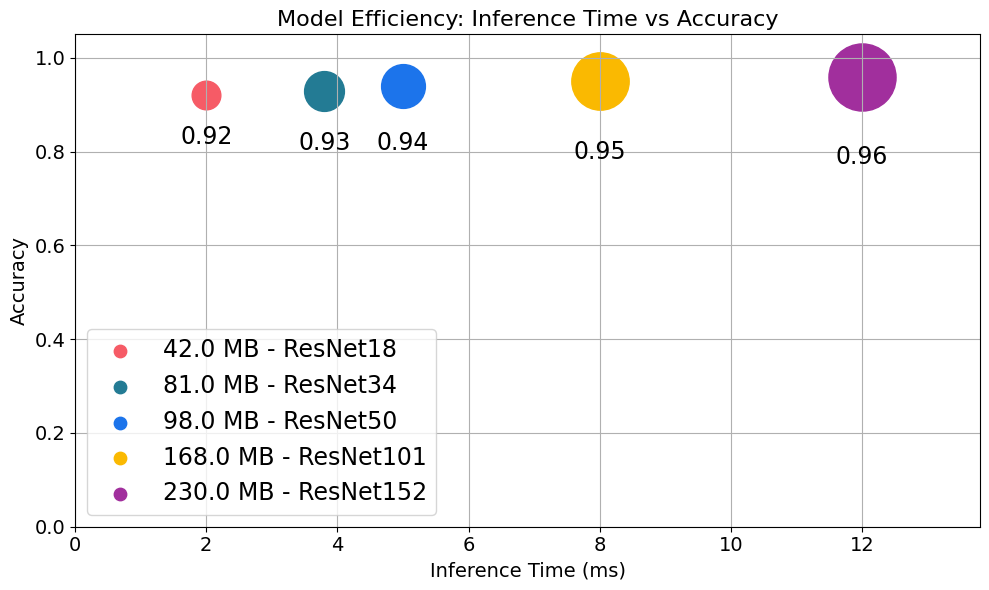

In [17]:
helper_utils.plot_efficiency_analysis(resnet_results)

You can see that as the model depth increases (from ResNet-18 to ResNet-152), both the model size and inference time increase. 
In other words, deeper models tend to be larger and slower.
Depending on the application constraints (e.g., real-time inference vs. accuracy needs), selecting the appropriate model requires balancing model complexity and efficiency.

Now you can run the two functions to select the best model based on the given constraints and criteria.

In [18]:
best_model_weighted, weighted_scores = select_best_model_weighted(resnet_results)

print(f"Best model by weighted criteria: {best_model_weighted}")
print("Weighted scores:")
pprint(weighted_scores)

Best model by weighted criteria: ResNet50
Weighted scores:
{'ResNet101': 0.5609574468085103,
 'ResNet152': 0.5,
 'ResNet18': 0.5,
 'ResNet34': 0.5295106382978727,
 'ResNet50': 0.6004255319148929}


In [19]:
best_model_constrains, viable_models = select_best_model_constraint_based(resnet_results, max_size_mb=100, max_inference_ms=4)

print(f"Best model by constraints: {best_model_constrains}")
print("Viable models:")
pprint(viable_models)

Best model by constraints: ResNet34
Viable models:
{'ResNet18': {'accuracy': 0.92,
              'depth': 18,
              'inference_time_ms': 2.0,
              'model_size_mb': 42},
 'ResNet34': {'accuracy': 0.93,
              'depth': 34,
              'inference_time_ms': 3.8,
              'model_size_mb': 81}}


Observe that depending on the constraints and criteria, the selected model may vary.
For the weighted criteria, even if the ResNet-152 has the highest accuracy, it is not the one with the best score (due to its larger size and longer inference time).

## Conclusion

Congratulations on reaching the conclusion of this practical tour of model selection and efficiency evaluation in PyTorch! This notebook has illustrated not only how to train and assess powerful neural network architectures, but also how to weigh critical efficiency metrics that directly affect model deployment and usability.

Key steps in this workflow included training compact and complex models, calculating resource costs.
Moreover, automated model selection was explored through both weighted objective functions and strict constraint filtering, highlighting the trade-offs between accuracy, speed, and memory footprint across different scenarios.

By working through these tasks, you'll gain a richer, more practical understanding of what it takes to select the most suitable model for a given application. 
These techniques empower practitioners to make informed, data-driven decisions tailored to real-world technological and operational constraints, laying a strong foundation for robust, efficient machine learning system design.